<a href="https://colab.research.google.com/github/CharlemagneBrain/ECG_Image_Preprocessing/blob/main/Setting_up_an_ECG_Function_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Traitement des images d'électrocardiogrammes pour la Prédiction de fibrillation Auriculaire sur une population porteuse de Pacemakers.

- Rogner l'image
- Extraction des dérivations concernées par la fibrillation auriculaire
- Transformation en nuance de gris : lissage, seuillage Otsu
- Création d'images binaires avec une bonne valeure de seuil
Passer les valeurs booléennes de l'image binaire au numérique (True/False => 0/1)
- Réunion des deux images (des deux dérivations v1 et d2) en une seule image

Nous allons nous baser sur ces images pour entrainer un modèle afin de trouver les caractéristiques essentielles à la prédiction de la fibrillation auriculaire.
Tout d'abord nous allons réflèchir à une architecture de notre modèle.
- NB : les traits verticaux présents sur l'électrocardiogramme représente du bruit qui n'a pas pu être défait malgré les opérations de traitement d'image morphologique

Nous serions amener à penser qu'une architecture CRNN serait bien conforme au type de problème auquel nous nous confrontons car nos données finales seront des images binaires, et l'anomalie que nous voulons prédire à l'instant T sur des données à temps réelles se bases sur les données à l'instant T-1(series temporelles).

In [ ]:
# Librairies
!apt-get install poppler-utils 


import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
from skimage.filters import threshold_otsu,gaussian
from skimage.transform import resize
from numpy import asarray
from skimage import color

def boolstr_to_floatstr(v):
    if v == 'True':
        return '1'
    elif v == 'False':
        return '0'
    else:
        return v

def preprocessing_ecg(ecg):

  ecg = ecg[600:2500, 350:3300]
  v1 = ecg[100:320,1460:2160]
  d2 = ecg[300:520,0:700]
  derivations = [v1, d2]

  #convertir en nuance de gris
  grayscale_v1 = color.rgb2gray(derivations[0])
  grayscale_d2 = color.rgb2gray(derivations[1])

  # Lissage de l'image : consiste simplement à ** rendre l'image floue **. 
  # On peut également dire que le flou de l'image adoucit le changement de valeur de pixel
  # Le lissage peut éliminer ou rendre les bords moins visibles.

  blurred_image_v1 = gaussian(grayscale_v1, sigma=3.5)
  blurred_image_d2 = gaussian(grayscale_d2, sigma=3.5) 

  #seuil pour distinguer l'avant-plan et l'arrière-plan
  #utiliser le seuillage otsu 
  global_thresh_v1 = threshold_otsu(blurred_image_v1)
  global_thresh_d2 = threshold_otsu(blurred_image_d2)

  #création d'une image binaire grâce à une bonne valeur du seuil
  binary_global_v1 = blurred_image_v1 < global_thresh_v1
  binary_global_d2 = blurred_image_d2 < global_thresh_d2

  all_binary = [binary_global_v1, binary_global_d2]

  new_data_v1 = np.vectorize(boolstr_to_floatstr)(all_binary[0]).astype(int)
  new_data_d2 = np.vectorize(boolstr_to_floatstr)(all_binary[1]).astype(int)

  new_data = [new_data_v1, new_data_d2]
  derivations_finales = np.concatenate((new_data[0], new_data[1]), axis=1)
  return derivations_finales



Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.14).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


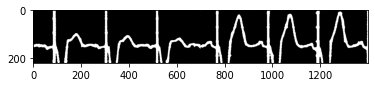

In [ ]:
# Visualisons 
# Importer notre drive
from google.colab import drive
drive.mount('/content/drive')

# Récupération du fichier ECG
path = "/content/drive/MyDrive/aziz.jpg"
ecg = cv.imread(path)

v1_d2 = preprocessing_ecg(ecg)

#Image finale
plt.imshow(v1_d2, cmap="gray");

In [ ]:
v1_d2.shape[1]

1400